# Data Prep and Pull
#### We will import our necessary packages and start pulling our data for data prep and usage.

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install --channel conda-forge geopandas geoplot geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# conda install -c anaconda beautiful-soup --yes
from bs4 import BeautifulSoup # package for parsing HTML and XML documents

import csv # implements classes to read and write tabular data in CSV form

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopandas
    - geoplot
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    contextily-1.0rc2          |             py_1          22 KB  conda-forge
    libgdal-3.0.2              |       h27ab9cc_0        18.8 MB
    libkml-1.3.0               |    h328b03d_1009         637 KB  conda-forge
    cartopy-0.17.0             |py36h423102d_1009         1.8 MB  conda-forge
    libcurl-7.67.0             |       h20c2e04_0         576 KB
    mapclassify-2.2.0          |             py_0          34 KB  conda-forge
    libspatialindex-1.9.3      |       he1b5a44_3         3.1 MB  conda-forge
    geotiff-1.5.1              |       h21e8280_0         284 KB
    munch-2.5.0                |             py_0          12 KB  conda-forge
    poppler-data-0.4.9    

# Finding the geo data for Hoboken
#### Let's find the geographic data for Hoboken so we can pull it from FourSquare.

In [18]:
address = 'Hoboken, New Jersey'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hoboken are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hoboken are 40.7433066, -74.0323752.


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


# FourSquare Part 1
#### Entering in our information into the Foursquare API to access it.

In [12]:
CLIENT_ID = '2BEQDHFUT2COMZUDGRWS0TK1ZPUSRKHBPGQYW1BISCW1OE0G' # your Foursquare ID
CLIENT_SECRET = 'AM0HEAK5J4HW5DSUARMMFDMPR3VCSNIVHYCVMPZEHTJN2HBP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2BEQDHFUT2COMZUDGRWS0TK1ZPUSRKHBPGQYW1BISCW1OE0G
CLIENT_SECRET:AM0HEAK5J4HW5DSUARMMFDMPR3VCSNIVHYCVMPZEHTJN2HBP


# FourSquare Part 2
#### Creating a URL for all of the venues in Hoboken

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=2BEQDHFUT2COMZUDGRWS0TK1ZPUSRKHBPGQYW1BISCW1OE0G&client_secret=AM0HEAK5J4HW5DSUARMMFDMPR3VCSNIVHYCVMPZEHTJN2HBP&v=20180605&ll=40.7433066,-74.0323752&radius=500&limit=100'

# FourSquare Part 3
#### Pulling the JSON for the URL of venues.

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e7cfdb7be61c9001ce36318'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Hoboken',
  'headerFullLocation': 'Hoboken',
  'headerLocationGranularity': 'city',
  'totalResults': 107,
  'suggestedBounds': {'ne': {'lat': 40.7478066045, 'lng': -74.0264467971303},
   'sw': {'lat': 40.738806595499995, 'lng': -74.0383036028697}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cdf46dadb125481eb4236ce',
       'name': 'Work It Out-A Fitness Boutique',
       'location': {'address': '603 Willow Ave',
        'lat': 40.744356367758414,
        'lng': -74.03256658205021,
        'labeledLatLngs': [{'label': 'displa

## Foursquare Part 4
#### Now we start pulling the data from Foursquare into a dataframe so we can manipulate and use it.

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Work It Out-A Fitness Boutique,4cdf46dadb125481eb4236ce,Gym / Fitness Center,40.744356,-74.032567
1,Sweet,4a4e740ff964a5207bae1fe3,Bakery,40.741623,-74.031523
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376
6,Anthropologie,51f1c7e1498e7425c21efab6,Women's Store,40.741838,-74.029662
7,Church Square Park,49e9e49df964a5200a661fe3,Park,40.742152,-74.032230
8,Dom's Bakery,4b660130f964a520ce0d2be3,Bakery,40.743387,-74.034836
9,Hoboken General Store,4b6b0a45f964a520a5ee2be3,Deli / Bodega,40.743148,-74.033030


In [24]:
#fix the column names so they look relatively normal

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Work It Out-A Fitness Boutique,4cdf46dadb125481eb4236ce,Gym / Fitness Center,40.744356,-74.032567
1,Sweet,4a4e740ff964a5207bae1fe3,Bakery,40.741623,-74.031523
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376
6,Anthropologie,51f1c7e1498e7425c21efab6,Women's Store,40.741838,-74.029662
7,Church Square Park,49e9e49df964a5200a661fe3,Park,40.742152,-74.032230
8,Dom's Bakery,4b660130f964a520ce0d2be3,Bakery,40.743387,-74.034836
9,Hoboken General Store,4b6b0a45f964a520a5ee2be3,Deli / Bodega,40.743148,-74.033030


In [25]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['categories'].unique()

array(['Gym / Fitness Center', 'Bakery', 'Cocktail Bar', 'Pub',
       'Bubble Tea Shop', 'Indian Restaurant', "Women's Store", 'Park',
       'Deli / Bodega', 'Bagel Shop', 'Sporting Goods Shop',
       'Falafel Restaurant', 'Sushi Restaurant', 'Coffee Shop',
       'American Restaurant', 'Cuban Restaurant', 'Ice Cream Shop', 'Bar',
       'Italian Restaurant', 'Burger Joint', 'Gaming Cafe',
       'South American Restaurant', 'Seafood Restaurant', 'Pizza Place',
       'Pet Store', 'Shoe Repair', 'Japanese Restaurant', 'Dog Run',
       'Yoga Studio', 'Paper / Office Supplies Store', 'Jewelry Store',
       'Sandwich Place', 'Poke Place', 'Boutique',
       'Mediterranean Restaurant', 'Optical Shop', 'Cosmetics Shop',
       'Sports Bar', 'Mexican Restaurant', 'Record Shop', 'Donut Shop',
       'Grocery Store', 'Gym', 'Thai Restaurant', 'Juice Bar', 'Dive Bar',
       'Stationery Store', 'Pilates Studio', 'Restaurant',
       'Korean Restaurant', 'Salon / Barbershop', 'Liquor Store'

In [26]:
# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Gym / Fitness Center', 'Bakery', 'Park', "Women's Store", 'Sporting Goods Shop', 'Dog Run', 'Gaming Cafe',
               'Optical Shop', 'Yoga Studio', 'Pet Store', 'Shoe Repair', 'Jewelry Store', 'Record Shop', 'Juice Bar', 
               'Cosmetics Shop', 'Business Service', 'Salon / Barbershop', 'Liquor Store', 'Grocery Store', 'Stationery Store',
               'Pilates Studio', 'Dessert Shop', 'Bookstore', 'Concert Hall', 'Video Game Store', 'Pharmacy', 'Mobile Phone Shop',
               'Deli / Bodega']

nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376
10,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173
13,Mamoun's Falafel,4d9368407b5ea1437d14c8b8,Falafel Restaurant,40.742303,-74.029465
14,Ayame Hibachi & Sushi,4dbc9859f7b1ab37dd636d12,Sushi Restaurant,40.743105,-74.029213
15,Empire Coffee & Tea,49f37b88f964a520a26a1fe3,Coffee Shop,40.741375,-74.030515
16,Zack's Oak Bar & Restaurant,49f26862f964a520296a1fe3,American Restaurant,40.740640,-74.033826
17,Court Street Bar & Restaurant,4a7eff1cf964a5206ff21fe3,American Restaurant,40.743322,-74.028615


## Foursquare Part 5
#### Now let's get a list of venue ids so we can pull likes and add to our dataframe.

In [27]:
#let's get a list of venues

venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['56d3b920498ec4e1c67c0907',
 '45e9482df964a52075431fe3',
 '57168865498e9517f09fa03d',
 '582dfc9565be5809f6a964ed',
 '56daf06fcd107605ef3d86ea',
 '4d9368407b5ea1437d14c8b8',
 '4dbc9859f7b1ab37dd636d12',
 '49f37b88f964a520a26a1fe3',
 '49f26862f964a520296a1fe3',
 '4a7eff1cf964a5206ff21fe3',
 '4eb1b6859adfb95b77765bf9',
 '49dfb562f964a52001611fe3',
 '4ad12c5ef964a5203ddd20e3',
 '4a7b5b6bf964a520c8ea1fe3',
 '53ed3b37498e4151087521a9',
 '4d4218cd607b6dcb31df08c6',
 '49e2a407f964a52045621fe3',
 '57f83f7acd10164c2ec1956f',
 '58e7ed715f67173549fe6246',
 '4ca50f407334236a60ef1258',
 '4cdb36c1958f236a15a7ab03',
 '4c60c4a1de6920a111ed9664',
 '4a9ac1b1f964a520813220e3',
 '527f3d1711d2f7f001c656b2',
 '4a9578dff964a520562320e3',
 '5df2bca6775cb40008715de3',
 '4a8da189f964a520501020e3',
 '58c470fd37da1d593431c33a',
 '4bddbf6be75c0f47f171c503',
 '4ad89c0bf964a520d31221e3',
 '5a6b6047f427de038c51031c',
 '4a3ad481f964a52057a01fe3',
 '4a775512f964a5202ee41fe3',
 '5065c556e4b0a44a76b324ce',
 '5c40edaaad91

In [29]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[72, 154, 30, 42, 69, 268, 71, 132, 121, 103, 170, 65, 46, 37, 85, 183, 105, 33, 71, 139, 83, 65, 166, 55, 76, 0, 77, 24, 4, 21, 38, 71, 71, 106, 5, 11, 38, 50, 121, 16, 0, 46, 6, 69, 34, 47, 111, 121, 10, 15, 17, 21, 27, 18, 20, 22, 23, 17, 6, 19, 16, 31]


In [30]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

62
62


# Data Prep Intro

#### The thought process behind this is that likes are a proxy for quality. The more likes there are, the better the restaurant is. This might be incorrect but API call issues (how many I can use for free) holds me back from getting price / rating data. I will then bin this data into a quality categorical variables so we can cluster appropriately.
#### I am also going to create new categorical variables for the restaurants to better group them based on type of cuisine. This way you can look for good mexican food or now what type of food might be best to eat in Hoboken if you are new to the area.

## Data Prep Part 1

#### Now let's start prepping our data for clustering. This will include combining data from different lists, creating new categorical data to be used, binning data and then encoding the data for clustering.

In [31]:
#let's make a copy of our initial dataframe just in case anything goes wrong

hoboken_venues = nearby_venues2.copy()
hoboken_venues.head()

,name,id,categories,lat,lng
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376
10,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173


## Data Prep Part 2
#### Let's combine our list of likes into our dataframe

In [32]:
# add in the list of likes

hoboken_venues['total likes'] = like_list
hoboken_venues.head()

,name,id,categories,lat,lng,total likes
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,72
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42
10,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69


## Data Prep Part 3
#### Let's look at our like data to set bins

In [33]:
# now let's bin total likes

print(hoboken_venues['total likes'].max())
print(hoboken_venues['total likes'].min())
print(hoboken_venues['total likes'].median())
print(hoboken_venues['total likes'].mean())

268
0
46.0
61.12903225806452


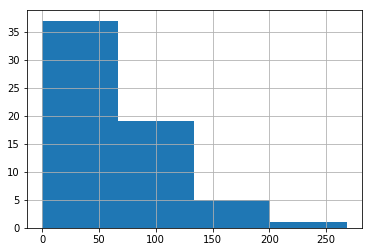

In [34]:
# let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
hoboken_venues['total likes'].hist(bins=4)
plt.show()

In [35]:
# what are the bins we want to use?

print(np.percentile(hoboken_venues['total likes'], 25))
print(np.percentile(hoboken_venues['total likes'], 50))
print(np.percentile(hoboken_venues['total likes'], 75))

20.25
46.0
81.5


In [36]:
# now we have our bin values so let's set them to the appropriate values
# less than 24, 24-45, 45-76, 76>
# poor, below avg, abv avg, great

poor = hoboken_venues['total likes']<=24
below_avg = hoboken_venues[(hoboken_venues['total likes']>24) & (hoboken_venues['total likes']<=45)]
abv_avg = hoboken_venues[(hoboken_venues['total likes']>45) & (hoboken_venues['total likes']<=76)]
great = hoboken_venues['total likes']>76

In [38]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=24:
        return 'poor'
    if s['total likes']<=45:
        return 'below avg'
    if s['total likes']<=76:
        return 'avg avg'
    if s['total likes']>76:
        return 'great'

hoboken_venues['total likes_cat']=hoboken_venues.apply(conditions, axis=1)

In [39]:
hoboken_venues

,name,id,categories,lat,lng,total likes,total likes_cat
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,72,avg avg
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154,great
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30,below avg
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42,below avg
10,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69,avg avg
13,Mamoun's Falafel,4d9368407b5ea1437d14c8b8,Falafel Restaurant,40.742303,-74.029465,268,great
14,Ayame Hibachi & Sushi,4dbc9859f7b1ab37dd636d12,Sushi Restaurant,40.743105,-74.029213,71,avg avg
15,Empire Coffee & Tea,49f37b88f964a520a26a1fe3,Coffee Shop,40.741375,-74.030515,132,great
16,Zack's Oak Bar & Restaurant,49f26862f964a520296a1fe3,American Restaurant,40.740640,-74.033826,121,great
17,Court Street Bar & Restaurant,4a7eff1cf964a5206ff21fe3,American Restaurant,40.743322,-74.028615,103,great


In [40]:
# let's start the process for re-categorizing the categories

hoboken_venues['categories'].unique()

array(['Cocktail Bar', 'Pub', 'Bubble Tea Shop', 'Indian Restaurant',
       'Bagel Shop', 'Falafel Restaurant', 'Sushi Restaurant',
       'Coffee Shop', 'American Restaurant', 'Cuban Restaurant',
       'Ice Cream Shop', 'Bar', 'Italian Restaurant', 'Burger Joint',
       'South American Restaurant', 'Seafood Restaurant', 'Pizza Place',
       'Japanese Restaurant', 'Paper / Office Supplies Store',
       'Sandwich Place', 'Poke Place', 'Boutique',
       'Mediterranean Restaurant', 'Sports Bar', 'Mexican Restaurant',
       'Donut Shop', 'Gym', 'Thai Restaurant', 'Dive Bar', 'Restaurant',
       'Korean Restaurant', 'Vietnamese Restaurant'], dtype=object)

In [41]:

# let's create our new categories and create a function to apply those to our existing data


bars = ['Pub', 'Cocktail Bar', 'Bar', 'Dive Bar', 'Sports Bar']
other = ['Bagel Shop', 'Tea Room', 'Donut Shop', 'Coffee Shop', 'Bubble Tea Shop', 'Sandwich Place', 'Boutique', 'Ice Cream Shop']
euro_asia_indian_food = ['Falafel Restaurant', 'Korean Restaurant','Sushi Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Poke Place', 'Thai Restaurant', 'Vietnamese Restaurant']
mex_southam_food = ['Cuban Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Latin American Restaurant']
american_food = ['Burger Joint', 'Restaurant', 'American Restaurant']
italian_food = ['Italian Restaurant', 'Seafood Restaurant', 'Pizza Place']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in euro_asia_indian_food:
        return 'euro asia indian food'
    if s['categories'] in mex_southam_food:
        return 'mex southam food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in italian_food:
        return 'italian food'

hoboken_venues['categories_new']=hoboken_venues.apply(conditions2, axis=1)

In [42]:
hoboken_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,72,avg avg,bars
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154,great,bars
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30,below avg,other
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42,below avg,euro asia indian food
10,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69,avg avg,other
13,Mamoun's Falafel,4d9368407b5ea1437d14c8b8,Falafel Restaurant,40.742303,-74.029465,268,great,euro asia indian food
14,Ayame Hibachi & Sushi,4dbc9859f7b1ab37dd636d12,Sushi Restaurant,40.743105,-74.029213,71,avg avg,euro asia indian food
15,Empire Coffee & Tea,49f37b88f964a520a26a1fe3,Coffee Shop,40.741375,-74.030515,132,great,other
16,Zack's Oak Bar & Restaurant,49f26862f964a520296a1fe3,American Restaurant,40.740640,-74.033826,121,great,american food
17,Court Street Bar & Restaurant,4a7eff1cf964a5206ff21fe3,American Restaurant,40.743322,-74.028615,103,great,american food


# Data Prep Part 4
 ### Now let's create dummy variables for our total likes and categories so we can cluster

In [43]:
# one hot encoding
hoboken_onehot = pd.get_dummies(hoboken_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hoboken_onehot['Name'] = hoboken_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [hoboken_onehot.columns[-1]] + list(hoboken_onehot.columns[:-1])
hoboken_onehot = hoboken_onehot[fixed_columns]

hoboken_onehot.head()

,Name,american food,bars,euro asia indian food,italian food,mex southam food,other,avg avg,below avg,great,poor
2,Grand Vin,0,1,0,0,0,0,1,0,0,0
3,Onieal's Restaurant & Bar,0,1,0,0,0,0,0,0,1,0
4,Kung Fu Tea,0,0,0,0,0,1,0,1,0,0
5,Karma Kafe,0,0,1,0,0,0,0,1,0,0
10,O'Bagel,0,0,0,0,0,1,1,0,0,0


## Clustering Part 1
#### Now let's run our k-means clustering algo to get our labels

In [44]:
cluster_df = hoboken_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 3, 3, 2, 0, 2, 0, 0, 0], dtype=int32)

## Clustering Part 2
#### Let's add our cluster labels back into our original dataframe.

In [45]:
hoboken_venues['label'] = kmeans.labels_
hoboken_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,72,avg avg,bars,2
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154,great,bars,0
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30,below avg,other,3
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42,below avg,euro asia indian food,3
10,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69,avg avg,other,2


## Clustering Part 3
#### Now let's visualize what our clusters look like for Hoboken.

In [ ]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hoboken_venues['lat'], hoboken_venues['lng'], hoboken_venues['name'], hoboken_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Clustering Part 4
### Now let's see what is in each of our clusters

#### Cluster 1
#### characteristics
#### Poor quality food
#### Mostly Italian food or other

In [49]:
hoboken_venues.loc[hoboken_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
3,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154,great,bars,0
13,Mamoun's Falafel,4d9368407b5ea1437d14c8b8,Falafel Restaurant,40.742303,-74.029465,268,great,euro asia indian food,0
15,Empire Coffee & Tea,49f37b88f964a520a26a1fe3,Coffee Shop,40.741375,-74.030515,132,great,other,0
16,Zack's Oak Bar & Restaurant,49f26862f964a520296a1fe3,American Restaurant,40.740640,-74.033826,121,great,american food,0
17,Court Street Bar & Restaurant,4a7eff1cf964a5206ff21fe3,American Restaurant,40.743322,-74.028615,103,great,american food,0
18,The Cuban,4eb1b6859adfb95b77765bf9,Cuban Restaurant,40.741012,-74.029732,170,great,mex southam food,0
24,Bareburger,53ed3b37498e4151087521a9,Burger Joint,40.742694,-74.029070,85,great,american food,0
26,Cork City Pub,4d4218cd607b6dcb31df08c6,Pub,40.740105,-74.030868,183,great,bars,0
27,Cucharamama,49e2a407f964a52045621fe3,South American Restaurant,40.740807,-74.034582,105,great,mex southam food,0
30,Grimaldi's,4ca50f407334236a60ef1258,Pizza Place,40.741674,-74.029578,139,great,italian food,0


## Cluster 2
#### characteristics
#### below average quality food
#### Mostly Europe / Asia inspired food

In [50]:
hoboken_venues.loc[hoboken_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
40,Paper Source,5df2bca6775cb40008715de3,Paper / Office Supplies Store,40.742185,-74.029320,0,poor,None,1
43,Makai Poke Co,58c470fd37da1d593431c33a,Poke Place,40.742852,-74.029213,24,poor,euro asia indian food,1
44,Townhouse No 620,4bddbf6be75c0f47f171c503,Boutique,40.744128,-74.029070,4,poor,other,1
45,Mr Wrap's,4ad89c0bf964a520d31221e3,American Restaurant,40.746308,-74.030003,21,poor,american food,1
56,Gong Cha,5c40edaaad910e0039b9fc01,Bubble Tea Shop,40.743034,-74.029034,5,poor,other,1
57,Pita Pit,56f136ad498ecc5661aa49ce,Sandwich Place,40.745729,-74.028582,11,poor,other,1
61,Napoli’s Pizzeria,59fd168ec21cb1401894e47e,Pizza Place,40.739404,-74.034909,16,poor,italian food,1
63,Planet Fitness - Temporarily Closed,5c6ba79f12c8f0002c2bdf71,Gym,40.743673,-74.028801,0,poor,None,1
65,francesca's,56c5003ccd10e29c9c30a7f8,Boutique,40.740742,-74.030123,6,poor,other,1
75,Flatbread Grill,55d52901498ea18f871d5f9e,Restaurant,40.742736,-74.028977,10,poor,american food,1


## Cluster 3
#### characteristics
#### High quality food
#### Mostly Mexican and South American food

In [51]:
hoboken_venues.loc[hoboken_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,72,avg avg,bars,2
10,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69,avg avg,other,2
14,Ayame Hibachi & Sushi,4dbc9859f7b1ab37dd636d12,Sushi Restaurant,40.743105,-74.029213,71,avg avg,euro asia indian food,2
21,Ben & Jerry's,49dfb562f964a52001611fe3,Ice Cream Shop,40.741430,-74.029484,65,avg avg,other,2
22,Moran's Pub,4ad12c5ef964a5203ddd20e3,Bar,40.742553,-74.031192,46,avg avg,bars,2
29,Bluestone Lane,58e7ed715f67173549fe6246,Coffee Shop,40.741601,-74.029410,71,avg avg,other,2
34,Dozzino,4c60c4a1de6920a111ed9664,Pizza Place,40.744612,-74.035632,65,avg avg,italian food,2
36,Otto Strada,527f3d1711d2f7f001c656b2,Italian Restaurant,40.746604,-74.031161,55,avg avg,italian food,2
37,Illuzion,4a9578dff964a520562320e3,Japanese Restaurant,40.741229,-74.029582,76,avg avg,euro asia indian food,2
50,Mikie Squared Bar & Grill,4a3ad481f964a52057a01fe3,Sports Bar,40.744032,-74.028956,71,avg avg,bars,2



## Cluster 4
#### characteristics
#### Above average quality food
#### Mostly Bars

In [52]:
hoboken_venues.loc[hoboken_venues['label']==3]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
4,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30,below avg,other,3
5,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42,below avg,euro asia indian food,3
23,Cafe Michelina,4a7b5b6bf964a520c8ea1fe3,Italian Restaurant,40.742278,-74.030218,37,below avg,italian food,3
28,Tutta Pesca,57f83f7acd10164c2ec1956f,Seafood Restaurant,40.740163,-74.031284,33,below avg,italian food,3
46,Mamoun's Falafel,5a6b6047f427de038c51031c,Mediterranean Restaurant,40.740090,-74.030374,38,below avg,None,3
58,Dunkin',4b191a58f964a520ffd723e3,Donut Shop,40.744912,-74.028920,38,below avg,other,3
69,Trattoria Saporito,4a9c695cf964a520153720e3,Italian Restaurant,40.740996,-74.029827,34,below avg,italian food,3
81,Frankie & Ava's Italian Eatery,567b01d8498e9310602c8d10,Italian Restaurant,40.739127,-74.030450,27,below avg,italian food,3
98,Pho Nomenon,529fc55011d2e9632e382ae3,Vietnamese Restaurant,40.742733,-74.029298,31,below avg,euro asia indian food,3
